In [307]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [325]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [340]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


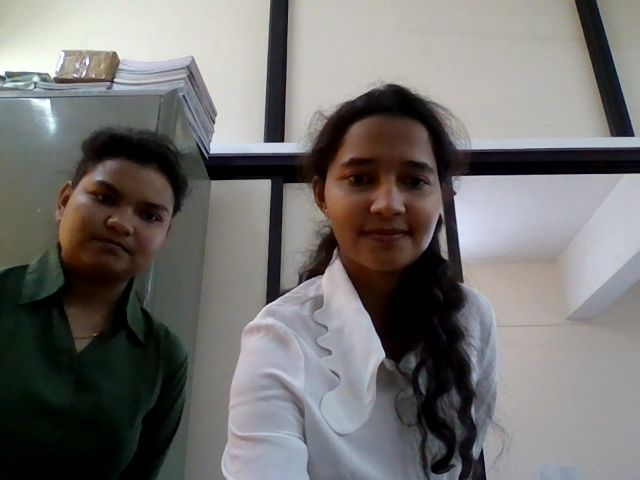

In [341]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [342]:
prototxtPath = "/content/drive/MyDrive/FaceDetection/deploy.prototxt.txt"
weightsPath = "/content/drive/MyDrive/FaceDetection/res10_300x300_ssd_iter_140000.caffemodel"
detector = cv2.dnn.readNet(prototxtPath, weightsPath)

In [343]:
#image = cv2.imread("deepface/tests/dataset/img1.jpg")
image = cv2.imread("photo.jpg")
base_img = image.copy()


In [344]:
original_size = image.shape
target_size = (300, 300)
print("original image size: ", original_size)


original image size:  (480, 640, 3)


In [345]:
image = cv2.resize(image, target_size)


In [346]:
aspect_ratio_x = (original_size[0] / target_size[0])
aspect_ratio_y = (original_size[1] / target_size[1])
print("aspect ratios x: ",aspect_ratio_x,", y: ", aspect_ratio_y)


aspect ratios x:  1.6 , y:  2.1333333333333333


In [347]:
image.shape

(300, 300, 3)

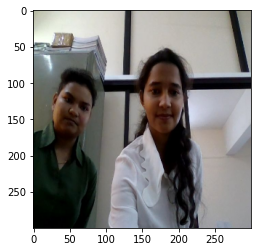

In [348]:
plt.imshow(image[:,:,::-1])

In [349]:
#detector expects (1, 3, 300, 300) shaped input
imageBlob = cv2.dnn.blobFromImage(image = image)  #the cv2.dnn.blobFromImage function returns a blob which is our input image after mean subtraction, normalizing, and channel swapping.
#imageBlob = np.expand_dims(np.rollaxis(image, 2, 0), axis = 0)


In [350]:
detector.setInput(imageBlob)
detections = detector.forward()
detections[0][0].shape


(200, 7)

In [351]:
detections_df = pd.DataFrame(detections[0][0]
 , columns = ["img_id", "is_face", "confidence", "left", "top", "right", "bottom"])


In [352]:
detections_df = detections_df[detections_df['is_face'] == 1] #0: background, 1: face
detections_df = detections_df[detections_df['confidence'] >= 0.90]


In [353]:
detections_df.head()

,img_id,is_face,confidence,left,top,right,bottom
0,0.0,1.0,0.999814,0.102845,0.327046,0.272170,0.572321
1,0.0,1.0,0.999710,0.512291,0.242858,0.689936,0.560125


Id  0
Confidence:  99.98 %


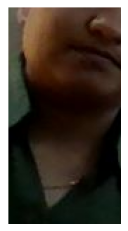

Id  1
Confidence:  99.97 %


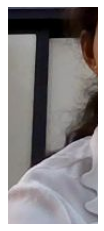

In [354]:
for i, instance in detections_df.iterrows():
    #print(instance)
    
    confidence_score = str(round(100*instance["confidence"], 2))+" %"
    
    left = int(instance["left"] * 300)
    bottom = int(instance["bottom"] * 300)
    right = int(instance["right"] * 300)
    top = int(instance["top"] * 300)
        
    #low resolution
    #detected_face = image[top:bottom, left:right]
    
    #high resolution
    detected_face = base_img[int(top*aspect_ratio_y):int(bottom*aspect_ratio_y), int(left*aspect_ratio_x):int(right*aspect_ratio_x)]
    
    if detected_face.shape[0] > 0 and detected_face.shape[1] > 0:
        
        #plt.figure(figsize = (3, 3))
        
        #low resolution
        #cv2.putText(image, confidence_score, (left, top-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        #cv2.rectangle(image, (left, top), (right, bottom), (255, 255, 255), 1) #draw rectangle to main image
        
        #high resolution
        cv2.putText(base_img, confidence_score, (int(left*aspect_ratio_x), int(top*aspect_ratio_y-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        cv2.rectangle(base_img, (int(left*aspect_ratio_x), int(top*aspect_ratio_y)), (int(right*aspect_ratio_x), int(bottom*aspect_ratio_y)), (255, 255, 255), 1) #draw rectangle to main image
        
        #-------------------
        
        print("Id ",i)
        print("Confidence: ", confidence_score)
        #detected_face = cv2.resize(detected_face, (224, 224))
        plt.imshow(detected_face[:,:,::-1])
        plt.axis('off')
        plt.show()

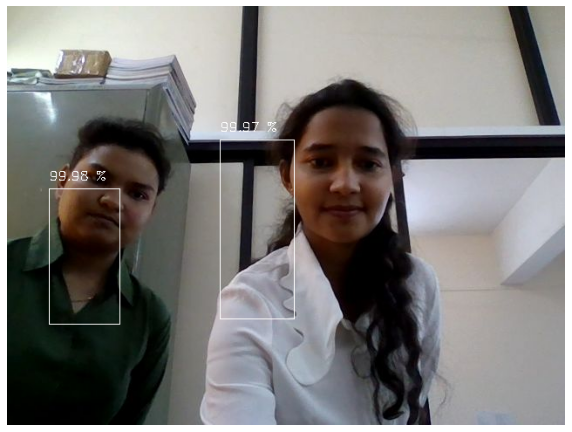

In [355]:
plt.figure(figsize = (10, 10))
#tmp_img = image.copy()
#tmp_img = cv2.resize(tmp_img, (300, 300))

plt.imshow(base_img[:,:,::-1])
plt.axis('off')
plt.show()

In [ ]:
base_img.shape

(480, 640, 3)